# Generate Whole sky map using best model in test set in CUBE 3

## packages 

In [1]:
from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse
from astropy.io import fits

import glob
import pickle
import Models
import os
import sys
import PIL
import data_loader
import sys, os

In [2]:
print(os.getcwd())

C:\Users\jueda\Desktop\HI\HI\ML\Experiment_4_10trails


## path

In [3]:

base_path = os.getcwd()
data_path  = os.path.join(base_path, 'data')
data_cube_path = os.path.join(data_path, 'saury2014','cubes')
fcnm_path = os.path.join(data_path, 'saury2014','fcnm')
rhi_path = os.path.join(data_path, 'saury2014','RHI')
print(data_cube_path)
print(fcnm_path)
print(rhi_path)

C:\Users\jueda\Desktop\HI\HI\ML\Experiment_4_10trails\data\saury2014\cubes
C:\Users\jueda\Desktop\HI\HI\ML\Experiment_4_10trails\data\saury2014\fcnm
C:\Users\jueda\Desktop\HI\HI\ML\Experiment_4_10trails\data\saury2014\RHI


In [4]:
# Training and test datasets
# 1. Datacubes: 04 datacubes with size of (512 x 512 x 101)
training_data_file_q0 = 'Tb_n01_pw02_vs12_512_thick_quarter_0_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q1 = 'Tb_n01_pw02_vs12_512_thick_quarter_1_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q2 = 'Tb_n01_pw02_vs12_512_thick_quarter_2_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q3 = 'Tb_n01_pw02_vs12_512_thick_quarter_3_noise_1.0_K_beam_1.45_pix_.fits'

training_data_file_q0 = os.path.join(data_cube_path, training_data_file_q0)
training_data_file_q1 = os.path.join(data_cube_path, training_data_file_q1)
training_data_file_q2 = os.path.join(data_cube_path, training_data_file_q2)
training_data_file_q3 = os.path.join(data_cube_path, training_data_file_q3)

# 2a. R_HI maps
rhi_file_q0 = 'R_map_n01_pw02_vs12_512px_quarter_0_noise.fits'
rhi_file_q1 = 'R_map_n01_pw02_vs12_512px_quarter_1_noise.fits'
rhi_file_q2 = 'R_map_n01_pw02_vs12_512px_quarter_2_noise.fits'
rhi_file_q3 = 'R_map_n01_pw02_vs12_512px_quarter_3_noise.fits'

rhi_file_q0 = os.path.join(rhi_path, rhi_file_q0)
rhi_file_q1 = os.path.join(rhi_path, rhi_file_q1)
rhi_file_q2 = os.path.join(rhi_path, rhi_file_q2)
rhi_file_q3 = os.path.join(rhi_path, rhi_file_q3)

# 3a. FCNM maps with noise
fcnm_file_q0 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0_noise.fits'
fcnm_file_q1 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_1_noise.fits'
fcnm_file_q2 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_2_noise.fits'
fcnm_file_q3 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_3_noise.fits'

fcnm_file_q0 = os.path.join(fcnm_path, fcnm_file_q0)
fcnm_file_q1 = os.path.join(fcnm_path, fcnm_file_q1)
fcnm_file_q2 = os.path.join(fcnm_path, fcnm_file_q2)
fcnm_file_q3 = os.path.join(fcnm_path, fcnm_file_q3)

print(training_data_file_q0)
print(fcnm_file_q0)
print(rhi_file_q0)

C:\Users\jueda\Desktop\HI\HI\ML\Experiment_4_10trails\data\saury2014\cubes\Tb_n01_pw02_vs12_512_thick_quarter_0_noise_1.0_K_beam_1.45_pix_.fits
C:\Users\jueda\Desktop\HI\HI\ML\Experiment_4_10trails\data\saury2014\fcnm\fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0_noise.fits
C:\Users\jueda\Desktop\HI\HI\ML\Experiment_4_10trails\data\saury2014\RHI\R_map_n01_pw02_vs12_512px_quarter_0_noise.fits


## Data Preparation

In [5]:
cube1, header1 = fits.getdata(training_data_file_q0, header=True)
cube2, header2 = fits.getdata(training_data_file_q1, header=True)
cube3, header3 = fits.getdata(training_data_file_q2, header=True)
cube4, header4 = fits.getdata(training_data_file_q3, header=True)
#
fcnm_data1, header1 = fits.getdata(fcnm_file_q0, header=True)
fcnm_data2, header2 = fits.getdata(fcnm_file_q1, header=True)
fcnm_data3, header3 = fits.getdata(fcnm_file_q2, header=True)
fcnm_data4, header4 = fits.getdata(fcnm_file_q3, header=True)
#
rhi_data1, header1 = fits.getdata(rhi_file_q0, header=True)
rhi_data2, header2 = fits.getdata(rhi_file_q1, header=True)
rhi_data3, header3 = fits.getdata(rhi_file_q2, header=True)
rhi_data4, header4 = fits.getdata(rhi_file_q3, header=True)

In [6]:
print(cube3.shape)
print(fcnm_data3.shape)
print(rhi_data3.shape)

(101, 512, 512)
(512, 512)
(512, 512)


In [7]:
dictt = {}
# cube 3
num=512*512
for i in range(0, num):
    index=i
    row_index = index//512
    column_index = index%512
    dictt[i] = (cube3[:,row_index, column_index], [fcnm_data3[row_index, column_index], rhi_data3[row_index, column_index]], [0, row_index, column_index])

In [8]:
PEV = None

In [9]:
dataset_test = data_loader.spectra_cube_loader(dictt,
                                          transform=data_loader.ToTensor(),
                                          target_transform=data_loader.ToTensor(),
                                          pe=PEV)
test_loader = torch.utils.data.DataLoader(dataset = dataset_test,
                                          batch_size = 600,
                                          shuffle =False)

## Model

In [10]:
model =  Models.cnn_transformer_small(num_output=2,
                             in_channels=1,
                             input_row = 1,
                             input_column=101,
                             drop_out_rate=0,
                             lpe=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=model.to(device)
checkpoint = torch.load(f'./checkpoint/learnable_PEV.pth',map_location=device)
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

## Test method

In [11]:
def test(model, test_loader):
    """
    test the model.
    Parameters
    ----------
    model : model.
        the model.
    dictt: dict
        data.
    Returns
    -------
    error: The mean MSE in test set. 
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss_Fcnm = 0
    test_loss_Rhi = 0
    total = 0
    device = device
    loss_function = nn.MSELoss()
    with torch.no_grad():
        for index, (inputs, values) in enumerate(test_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            #
            true_fcnm = values[:,0]
            #print('true_fcnm = ', true_fcnm)
            true_Rhi = values[:,1]
            # forward 
            outputs = model(inputs)
            outputs_fcnm = outputs[:, 0]
            outputs_Rhi = outputs[:, 1]
            #print(outputs)
            #print(outputs[0][1])
            loss_fcnm = loss_function(outputs_fcnm, true_fcnm)
            loss_Rhi = loss_function(outputs_Rhi, true_Rhi)
            test_loss_Fcnm =test_loss_Fcnm+ (loss_fcnm.item()* values.size(0))
            test_loss_Rhi =test_loss_Rhi+ (loss_Rhi.item()* values.size(0))
            total += values.size(0)
        return test_loss_Fcnm/total , test_loss_Rhi/total

In [12]:
Loss_Fcnm, Loss_Rhi = test(model, test_loader)
print('Fcnm MSE=',Loss_Fcnm, ', Rhi MSE = ', Loss_Rhi)

Fcnm MSE= 0.003059461100040295 , Rhi MSE =  0.1437041498955366


In [13]:
"""
    predict: A method to predict the RHI and FCNM.
    
    input Attributes
    ----------
    dictt: dictionary 
        the  dictionary that contains only one data cube spectra.
"""
def predict(dictt):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    Fcnm = np.zeros((512,512,1))
    Rhi = np.zeros((512,512,1))
    for i in range(0, len(dictt)):
        if(i%10000==0):
            print(i,f'/{512*512}')
        o = dictt.get(i)
        spectra = np.array(o[0])
        spectra = spectra.reshape(1,1, 1,-1).astype(np.float32)
        spectra = torch.from_numpy(spectra)
        spectra = spectra.to(device)
        ground_truth = o[1]
        position = o[2]
        prediction = model(spectra)
        Fcnm[position[1], position[2]] =abs(prediction[0][0].cpu()).detach().numpy()
        Rhi[position[1], position[2]] =abs(prediction[0][1].cpu()).detach().numpy()
    return Fcnm, Rhi

In [14]:
Fcnm, Rhi = predict(dictt)

0 /262144
10000 /262144
20000 /262144
30000 /262144
40000 /262144
50000 /262144
60000 /262144
70000 /262144
80000 /262144
90000 /262144
100000 /262144
110000 /262144
120000 /262144
130000 /262144
140000 /262144
150000 /262144
160000 /262144
170000 /262144
180000 /262144
190000 /262144
200000 /262144
210000 /262144
220000 /262144
230000 /262144
240000 /262144
250000 /262144
260000 /262144


In [15]:
def plot_(im, title, label):
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='cividis')
    cbar = plt.colorbar(shrink=0.5, pad=0.005)
    cbar.set_label(f'${label}$', size=16)
    plt.title(f'{title}')
    plt.xlabel('X [Coordinate]')
    plt.ylabel('Y [Coordinate]')
    plt.show()

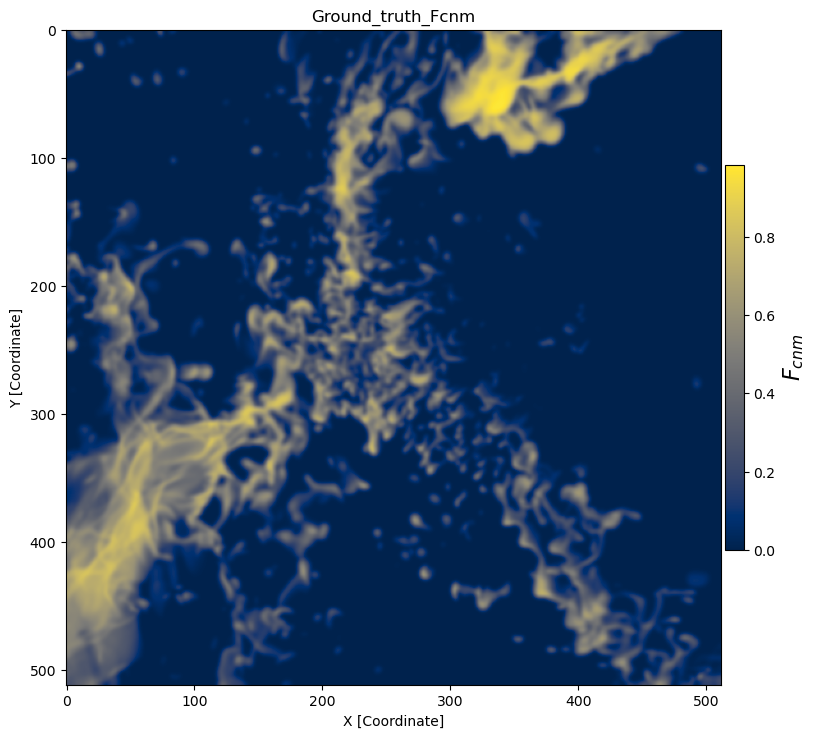

In [16]:
plot_(fcnm_data3, 'Ground_truth_Fcnm', 'F_{cnm}')

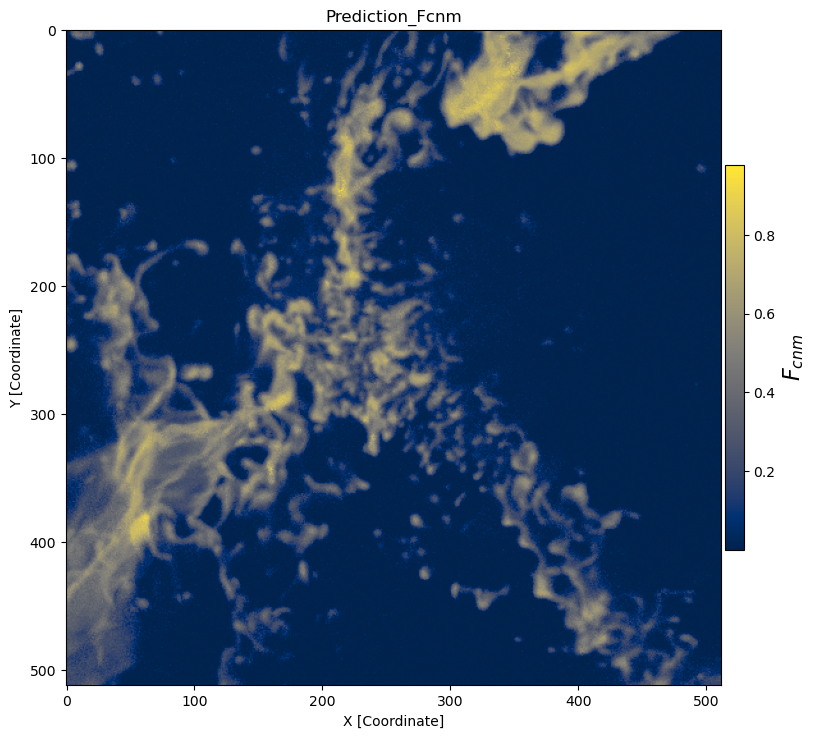

In [17]:
plot_(Fcnm, 'Prediction_Fcnm', 'F_{cnm}')

(512, 512)
(512, 512)


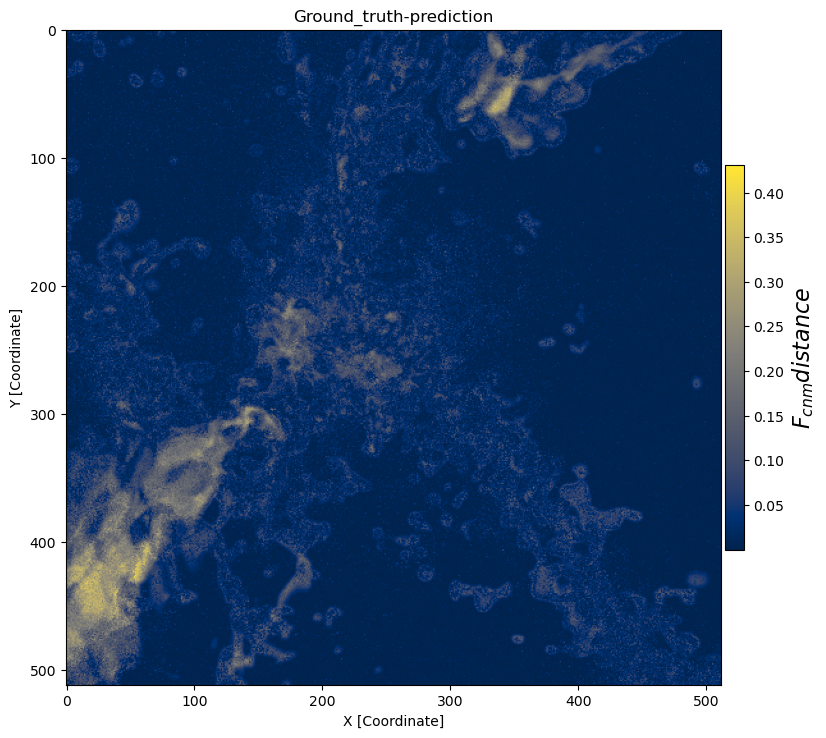

In [18]:
Fcnmm = Fcnm.squeeze()
print(Fcnmm.shape)
print(fcnm_data3.shape)
plot_(abs(abs(Fcnmm)-abs(fcnm_data3)), 'Ground_truth-prediction', 'F_{cnm} distance')

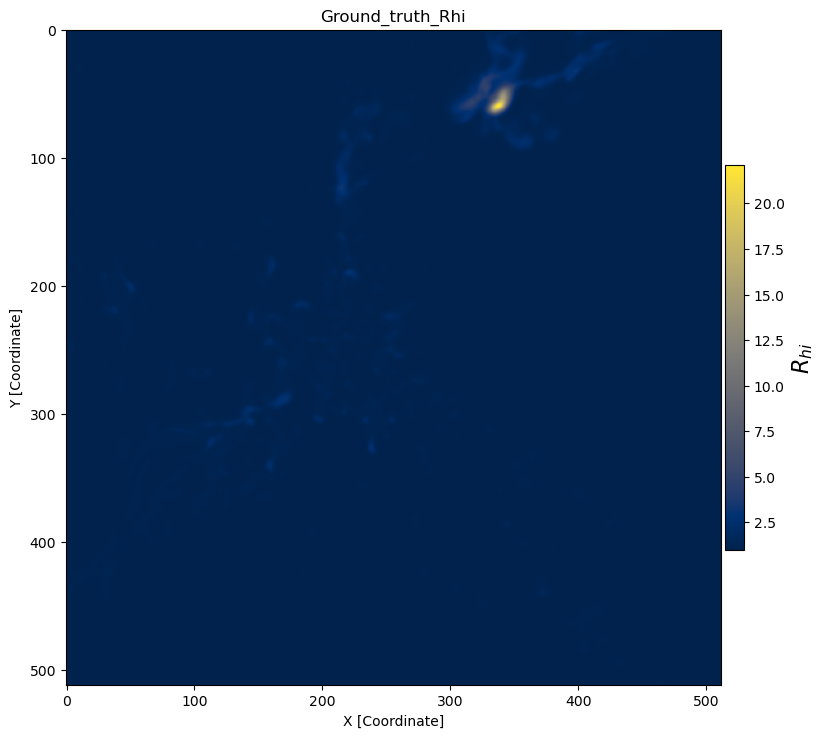

In [19]:
plot_(rhi_data3,'Ground_truth_Rhi','R_{hi}')

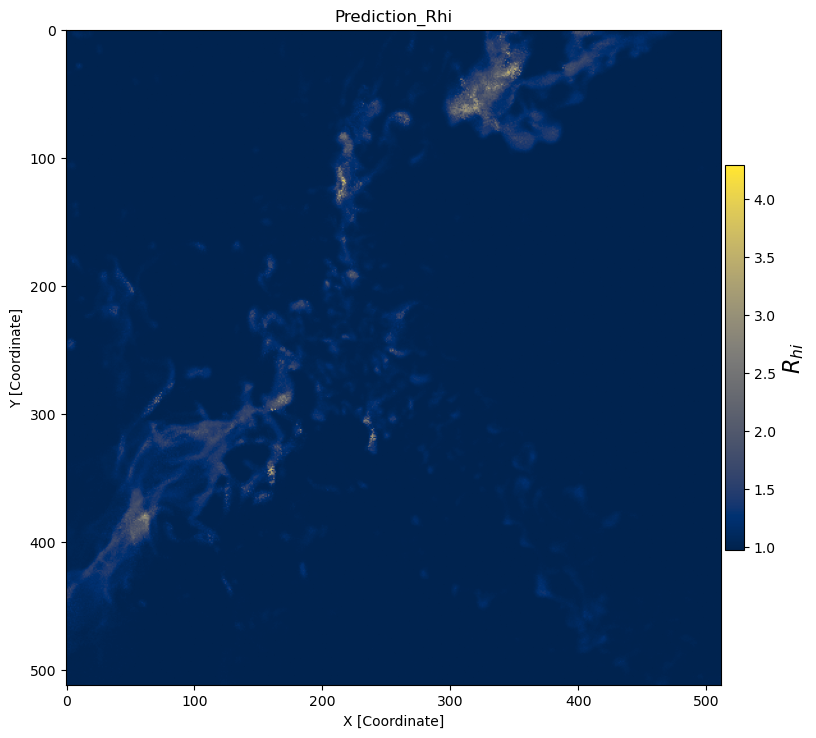

In [20]:
plot_(Rhi,'Prediction_Rhi','R_{hi}')

(512, 512)
(512, 512)


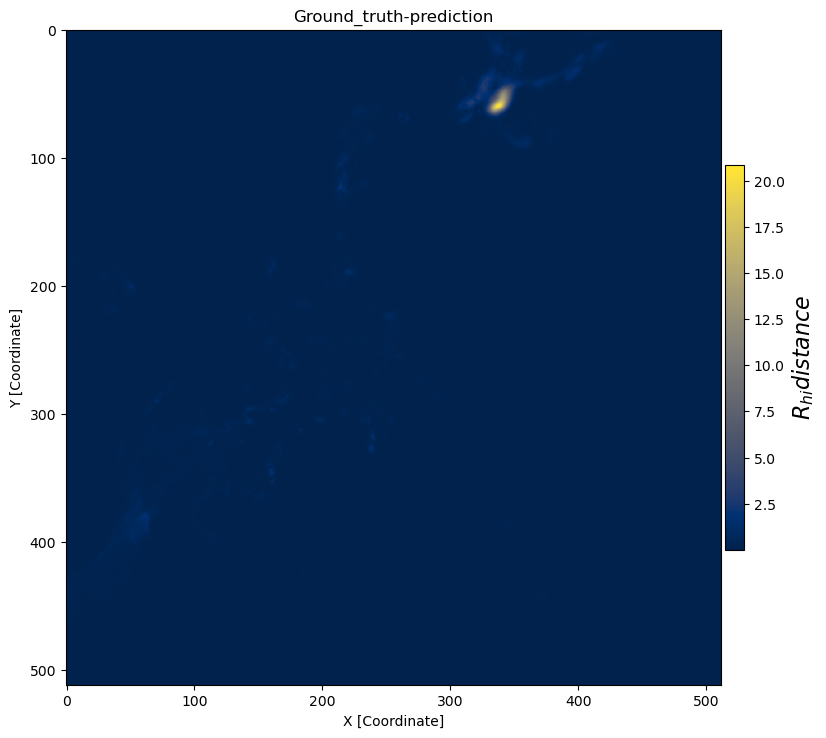

In [21]:
Rhii = Rhi.squeeze()
print(Rhii.shape)
print(rhi_data3.shape)
plot_(abs(abs(Rhii)-abs(rhi_data3)), 'Ground_truth-prediction', 'R_{hi} distance')